In [4]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import sys
import os
sys.path.append(os.path.abspath('..'))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Load data

In [5]:

X_data = joblib.load('../data/interim/05_X_new_features_scaled.joblib')
y_data = joblib.load('../data/interim/06_y_combined.joblib')

In [6]:
print(X_data.shape)
print(y_data.shape)

(356224, 91)
(356224, 3)


In [7]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356224 entries, 0 to 356223
Data columns (total 91 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Time                   356224 non-null  float64
 1   1_red                  356224 non-null  float64
 2   1_blue                 356224 non-null  float64
 3   1_yellow               356224 non-null  float64
 4   2_red                  356224 non-null  float64
 5   2_blue                 356224 non-null  float64
 6   2_yellow               356224 non-null  float64
 7   3_red                  356224 non-null  float64
 8   3_blue                 356224 non-null  float64
 9   3_yellow               356224 non-null  float64
 10  4_red                  356224 non-null  float64
 11  4_blue                 356224 non-null  float64
 12  4_yellow               356224 non-null  float64
 13  5_red                  356224 non-null  float64
 14  5_blue                 356224 non-nu

# Feature Selection

In [8]:
def remove_highly_correlated_features(X_data, threshold=0.9, verbose=True):
    """
    Returns names of features with reduced correlation (|corr| <= threshold).

    Parameters:
    - X_data (pd.DataFrame): The input DataFrame.
    - threshold (float): Correlation threshold to consider for removal.
    - verbose (bool): If True, prints the pairs and dropped columns.

    Returns:
    - remaining_features (list): List of remaining feature names.
    - dropped_features (list): List of dropped feature names.
    """
    # Compute correlation matrix
    corr_matrix = X_data.corr().abs()

    # Mask the diagonal and lower triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find highly correlated pairs
    high_corr_pairs = [
        (col1, col2, corr_value)
        for col1 in upper.columns
        for col2, corr_value in upper[col1].items()
        if corr_value > threshold
    ]

    # Optionally print the pairs
    if verbose:
        if high_corr_pairs:
            print("Highly correlated feature pairs:")
            for col1, col2, corr_value in high_corr_pairs:
                print(f"{col1} and {col2} : {corr_value:.2f}")
        else:
            print("No feature pairs exceed the correlation threshold.")

    # Identify columns to drop (second column of each pair)
    to_drop = {col2 for col1, col2, corr_value in high_corr_pairs}

    # Get remaining features
    remaining_features = [col for col in X_data.columns if col not in to_drop]

    # Optionally print the dropped and remaining columns
    if verbose:
        print(f"Dropped columns: {list(to_drop)}")
        print(f"Remaining columns: {len(remaining_features)} features")

    return remaining_features, list(to_drop)


In [9]:
original_features = X_data.iloc[:, 0:19].columns.tolist()
pca_features = [i for i in X_data.columns if "PCA" in i]
color_features = [i for i in X_data.columns if "color" in i]
rolling_features = [i for i in X_data.columns if "rolling" in i]
temporal_features = [i for i in X_data.columns if "diff" in i]
sensor_features = [i for i in X_data.columns if "block" in i]

print("Original Features:", len(original_features))
print("PCA Features:", len(pca_features))
print("Color Features:", len(color_features))
print("Rolling Features:", len(rolling_features))
print("Temporal Features:", len(temporal_features))
print("Sensor Features:", len(sensor_features))

Original Features: 19
PCA Features: 5
Color Features: 6
Rolling Features: 36
Temporal Features: 18
Sensor Features: 4


In [28]:
feature_set_1 = original_features
feature_set_2 = pca_features
feature_set_3 = original_features + rolling_features + temporal_features 
feature_set_4 = original_features + color_features + sensor_features
feature_set_5 = original_features + pca_features + color_features + rolling_features + temporal_features + sensor_features

### Remove features that are highly corr with one another 

In [ ]:
feature_set_6, dropped_columns = remove_highly_correlated_features(X_data, threshold=0.8, verbose=False)

### Feature Importance Ranking + Top-K Selection

In [12]:
def select_top_k_features_with_importance(X_data, y_data, top_k=10, model=None, n_jobs=-1):
    """
    Train a RandomForestRegressor and select top-k important features.

    Parameters:
    - X_data (pd.DataFrame): Feature matrix
    - y_data (pd.Series or pd.DataFrame): Target values
    - top_k (int): Number of top features to select
    - model (sklearn model, optional): Provide a pre-configured model if desired
    - n_jobs (int): Number of parallel jobs (-1 uses all cores)

    Returns:
    - top_features (list): List of top-k feature names
    - feature_importance_ranking (pd.DataFrame): Full ranking of features and importances
    """
    if model is None:
        model = RandomForestRegressor(n_jobs=n_jobs) 

    # Fit the model
    model.fit(X_data, y_data)

    # Get importances
    importances = model.feature_importances_
    feature_ranks = sorted(zip(X_data.columns, importances), key=lambda x: x[1], reverse=True)

    # Prepare outputs
    top_features = [f[0] for f in feature_ranks[:top_k]]
    feature_importance_ranking = pd.DataFrame(feature_ranks, columns=['Feature', 'Importance'])

    return top_features, feature_importance_ranking

In [13]:
feature_set_7, feature_importance_ranking = select_top_k_features_with_importance(X_data, y_data, top_k=10, n_jobs=-1)

In [14]:
print("Top 10 Features:", feature_set_7)
print(feature_importance_ranking.head(10))

Top 10 Features: ['1_blue_rolling_mean', '6_blue', '1_blue', '2_yellow_rolling_std', '1_red_rolling_mean', '1_yellow', 'global_std', '3_yellow', '3_red_rolling_std', '6_yellow']
                Feature  Importance
0   1_blue_rolling_mean    0.403088
1                6_blue    0.234097
2                1_blue    0.099106
3  2_yellow_rolling_std    0.073315
4    1_red_rolling_mean    0.057883
5              1_yellow    0.026352
6            global_std    0.011763
7              3_yellow    0.007368
8     3_red_rolling_std    0.006304
9              6_yellow    0.005401


In [ ]:
# results from above
# feature_set_7 = ['1_blue_rolling_mean', 
#                  '6_blue', 
#                  '1_blue', 
#                  '2_yellow_rolling_std', 
#                  '1_red_rolling_mean', 
#                  '1_yellow', 
#                  'global_std', 
#                  '3_yellow', 
#                  '3_red_rolling_std', 
#                  '6_yellow']

In [15]:
feature_subset_list = [
    feature_set_1, 
    feature_set_2, 
    feature_set_3, 
    feature_set_4, 
    feature_set_5, 
    feature_set_6, 
    feature_set_7
]

for i, subset in enumerate(feature_subset_list):
    print(f"length of feature_set_{i + 1}: ", len(subset))

length of feature_set_1:  19
length of feature_set_2:  5
length of feature_set_3:  73
length of feature_set_4:  29
length of feature_set_5:  88
length of feature_set_6:  33
length of feature_set_7:  10


### Visualize the important features

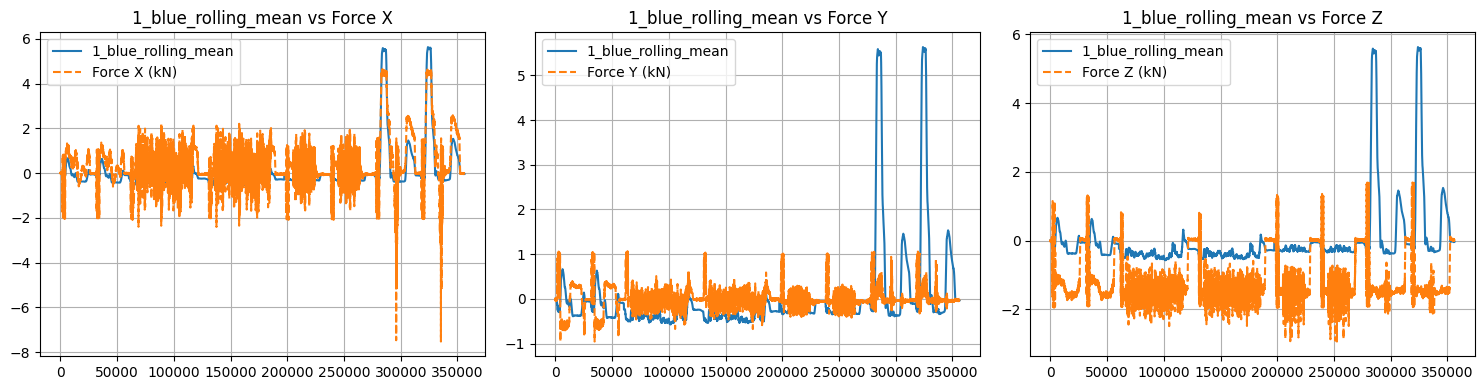

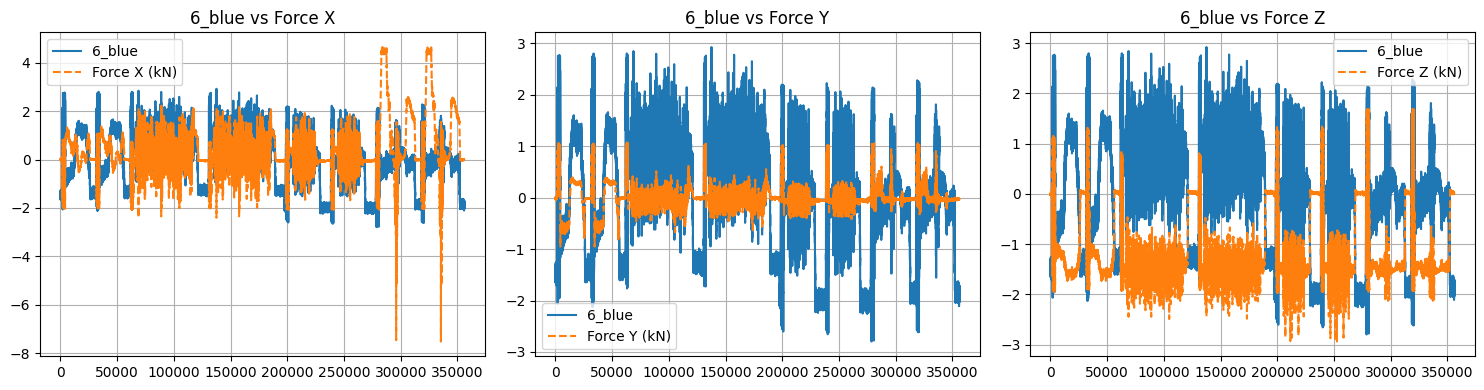

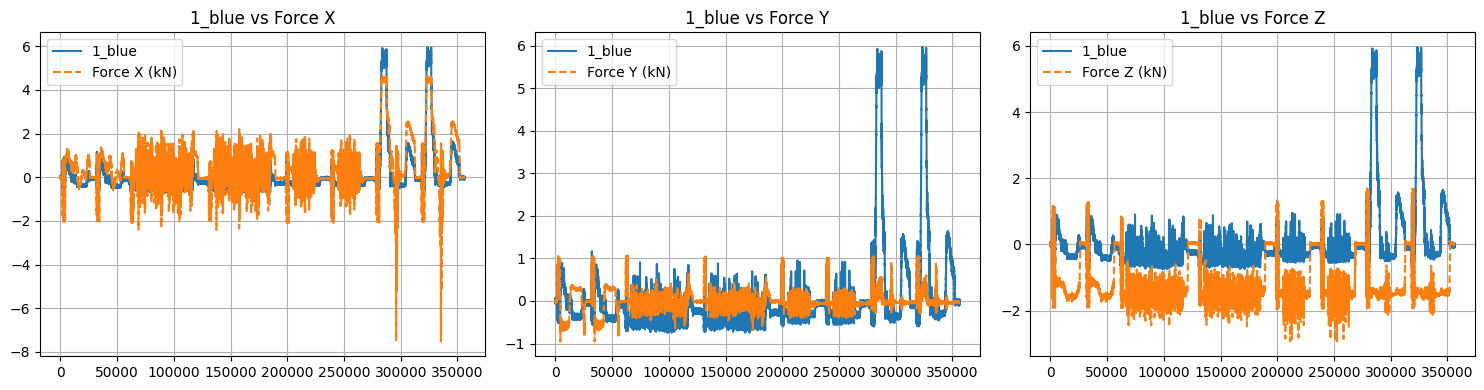

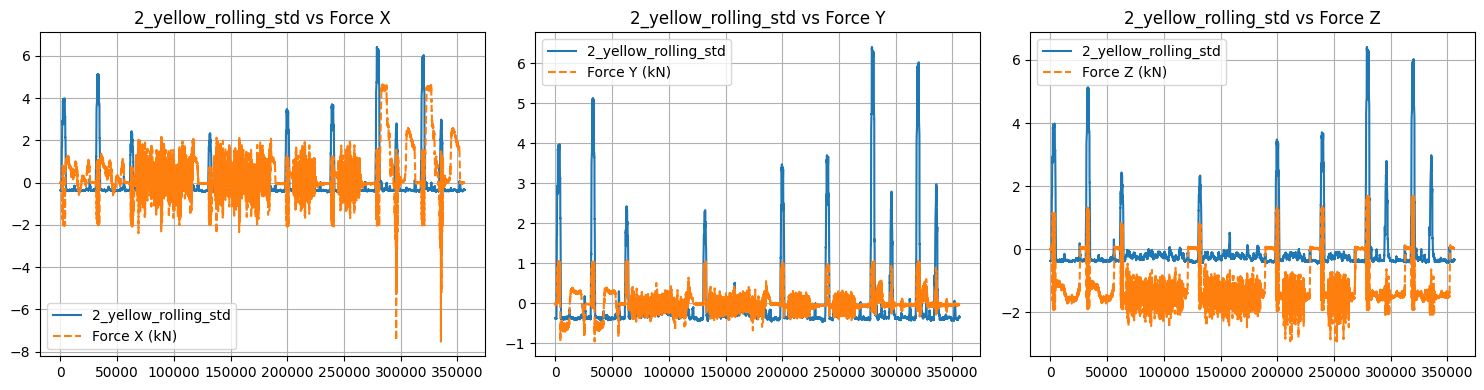

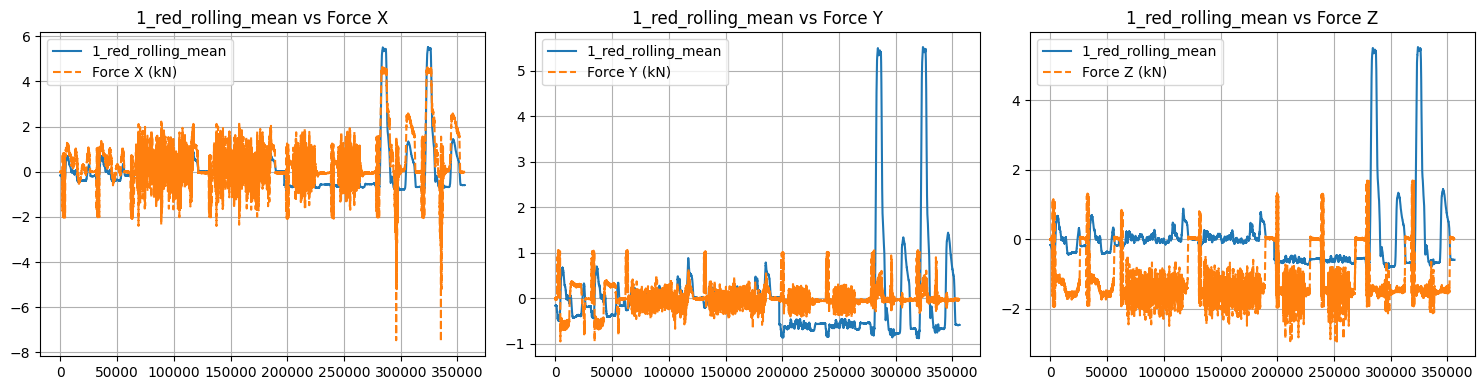

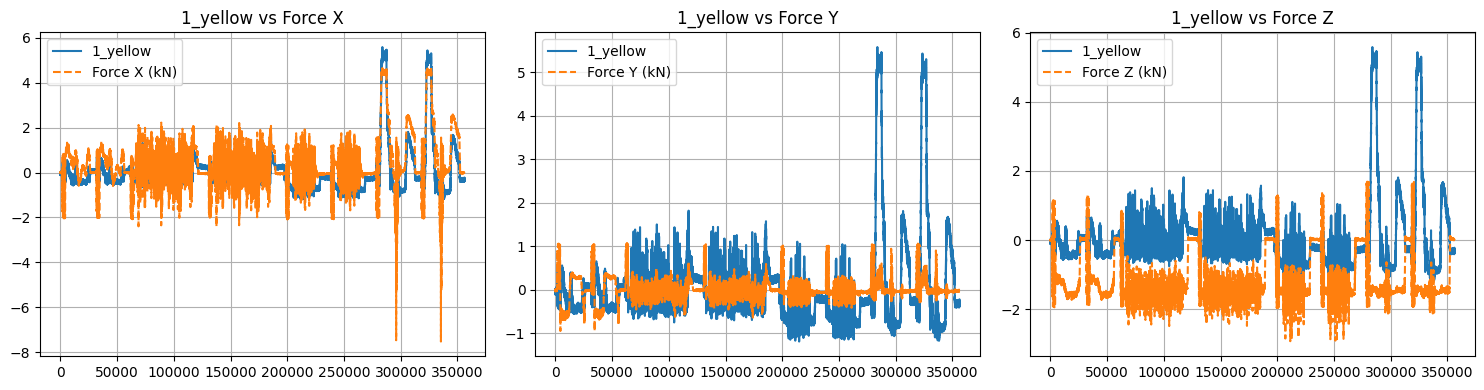

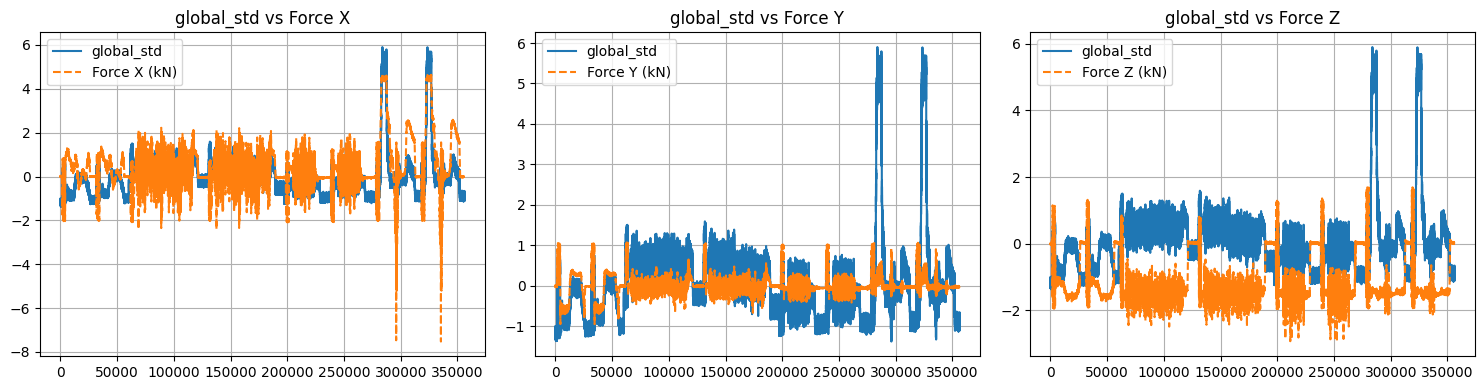

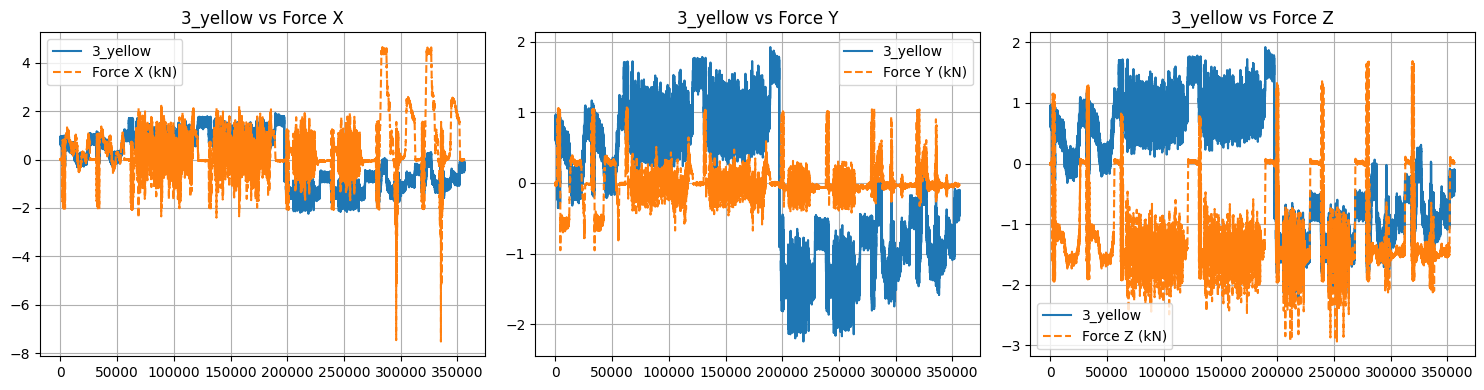

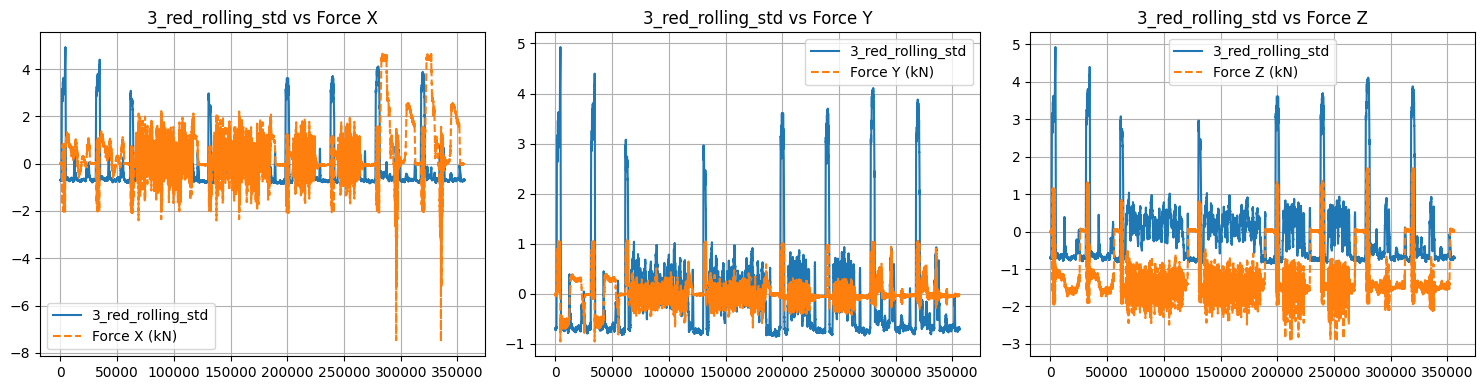

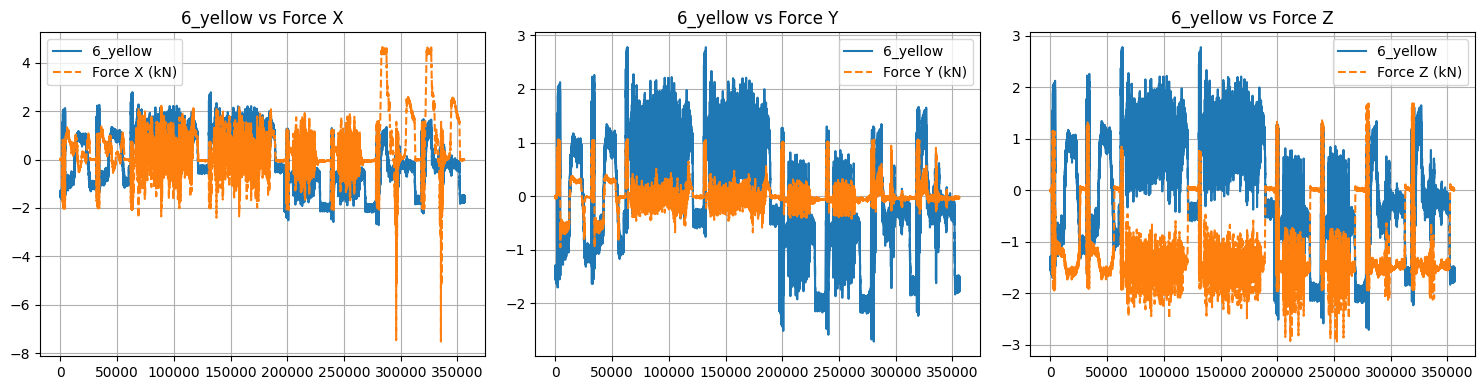

In [24]:
for feature in feature_set_7:
    plt.figure(figsize=(15, 4))
    
    # Plot against Force X
    plt.subplot(1, 3, 1)
    plt.plot(X_data[feature], label=feature)
    plt.plot(y_data['X (kN)'], label='Force X (kN)', linestyle='--')
    plt.title(f'{feature} vs Force X')
    plt.legend()
    plt.grid(True)
    
    # Plot against Force Y
    plt.subplot(1, 3, 2)
    plt.plot(X_data[feature], label=feature)
    plt.plot(y_data['Y (kN)'], label='Force Y (kN)', linestyle='--')
    plt.title(f'{feature} vs Force Y')
    plt.legend()
    plt.grid(True)
    
    # Plot against Force Z
    plt.subplot(1, 3, 3)
    plt.plot(X_data[feature], label=feature)
    plt.plot(y_data['Z (kN)'], label='Force Z (kN)', linestyle='--')
    plt.title(f'{feature} vs Force Z')
    plt.legend()
    plt.grid(True)
    
    # Display the combined figure
    plt.tight_layout()
    plt.show()

### Split data

In [16]:
# Split the data into training and validation (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [17]:
def evaluate_and_save_best_model_generic(
    X_train, y_train, X_val, y_val,
    feature_subsets,
    model_class,
    model_name,
    model_save_dir='../model/',
    multi_output=False,
    **model_kwargs
):
    """
    Generic function to evaluate multiple feature subsets with optional multi-output support,
    save the best model, and report performance.

    Parameters:
    - X_train, y_train, X_val, y_val: Pre-split data
    - feature_subsets (list): List of feature name lists
    - model_class: Scikit-learn model class (e.g., RandomForestRegressor)
    - model_name (str): Name to tag the saved model file
    - model_save_dir (str): Directory to save model
    - multi_output (bool): Whether to wrap with MultiOutputRegressor
    - model_kwargs: Additional model parameters

    Returns:
    - best_model: Trained best model
    - best_metrics (dict): R2, MAE, RMSE
    - best_features (list): Features used
    """
    best_r2 = -np.inf
    best_model = None
    best_metrics = {}
    best_features = []

    for idx, feature_subset in enumerate(feature_subsets, start=1):
        print(f"\nEvaluating Feature Set {idx} with {len(feature_subset)} features using {model_name}...")

        X_train_subset = X_train[feature_subset]
        X_val_subset = X_val[feature_subset]

        # Build model with optional multi-output wrapper
        base_model = model_class(**model_kwargs)
        model = MultiOutputRegressor(base_model) if multi_output else base_model
        
        print(f"Full model parameters:\n{base_model.get_params()}\n")

        # Train and predict
        model.fit(X_train_subset, y_train)
        y_pred = model.predict(X_val_subset)
         
        # Check and print iteration count if available for mlp
        if hasattr(model, 'n_iter_'):
            print(f"Model stopped after {model.n_iter_} iterations.")
        elif hasattr(model, 'estimators_') and hasattr(model.estimators_[0], 'n_iter_'):
            print(f"Model stopped after {model.estimators_[0].n_iter_} iterations (first output).")

        # Calculate metrics
        r2 = r2_score(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        print(f"R² Score: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

        # Update best model if better
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_metrics = {'R2': r2, 'MAE': mae, 'RMSE': rmse}
            best_features = feature_subset

    # Save best model
    os.makedirs(model_save_dir, exist_ok=True)
    model_path = os.path.join(model_save_dir, f'best_{model_name}.joblib')
    joblib.dump(best_model, model_path)
    print(f"\n✅ Best {model_name} model saved to: {model_path}")

    return best_model, best_metrics, best_features

In [ ]:
# Random Forest 
rf_model_2, rf_metrics_2, rf_features_2 = evaluate_and_save_best_model_generic(
    X_train, y_train, X_val, y_val,
    feature_subsets=feature_subset_list,
    model_class=RandomForestRegressor,
    model_name='random_forest',
    random_state=42,
    n_jobs=-1  
)


Evaluating Feature Set 1 with 19 features using random_forest...
Full model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

R² Score: 0.9754 | MAE: 0.0526 | RMSE: 0.1187

Evaluating Feature Set 2 with 5 features using random_forest...
Full model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

R² Score: 0.9255 | MAE: 0.103

For RF, best feature set is set 3 (73 features)

R² Score: 0.9936 | MAE: 0.0233 | RMSE: 0.0584

In [17]:
# HistGradientBoostingRegressor
gb_model_wrapped, gb_metrics, gb_features = evaluate_and_save_best_model_generic(
    X_train, y_train, X_val, y_val,
    feature_subsets=feature_subset_list,
    model_class=HistGradientBoostingRegressor,
    model_name='hist_gradient_boosting',
    multi_output=True,  
    random_state=42,
    max_iter=500,
    learning_rate=0.1,
    max_leaf_nodes=31,
    min_samples_leaf=20
)


Evaluating Feature Set 1 with 19 features using hist_gradient_boosting...
Full model parameters:
{'categorical_features': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 500, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None, 'random_state': 42, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

R² Score: 0.9675 | MAE: 0.0708 | RMSE: 0.1364

Evaluating Feature Set 2 with 5 features using hist_gradient_boosting...
Full model parameters:
{'categorical_features': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 500, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None, 'ran

For HGB, best feature set is 5 (88 features)


R² Score: 0.9874 | MAE: 0.0481 | RMSE: 0.0835

In [23]:
# MLP
mlp_model, mlp_metrics, mlp_features = evaluate_and_save_best_model_generic(
    X_train, y_train, X_val, y_val,
    feature_subsets=feature_subset_list,
    model_class=MLPRegressor,
    model_name='mlp',
    random_state=42,
    max_iter=1000,                
    hidden_layer_sizes=(100, 50), 
    activation='relu',           
    solver='adam',               
    learning_rate='adaptive',     
    early_stopping=True           
)


Evaluating Feature Set 1 with 19 features using mlp...
Full model parameters:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

Model stopped after 56 iterations.
R² Score: 0.9627 | MAE: 0.0760 | RMSE: 0.1431

Evaluating Feature Set 2 with 5 features using mlp...
Full model parameters:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0

For MLP, best feature set is set 3 (73 features)\
R² Score: 0.9835 | MAE: 0.0500 | RMSE: 0.0822

# Grid search for feature_set_7 

In [19]:
def grid_search_and_report_single_subset(
    X_train, y_train, X_val, y_val,
    feature_set,
    param_grid,
    model_class,
    model_name,
    model_save_dir='../model/',
    multi_output=False,
    scoring='neg_mean_squared_error',
    cv=5
):
    """
    GridSearchCV for a single feature set with optional multi-output support.
    Reports R2, MAE, RMSE on validation set and saves the best model.

    Returns:
    - best_model
    - best_params
    - validation_metrics
    """

    X_train_subset = X_train[feature_set]
    X_val_subset = X_val[feature_set]

    # Handle wrapping if needed
    base_model = model_class()
    model_to_search = MultiOutputRegressor(base_model) if multi_output else base_model

    # Prepare GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_to_search,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=2,
        scoring=scoring
    )

    # Run Grid Search
    grid_search.fit(X_train_subset, y_train)

    # Get Best Model and Params
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"\n✅ Best Parameters Found: {best_params}")

    # Evaluate on Validation Set
    y_pred = best_model.predict(X_val_subset)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    print(f"✅ Validation R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    # Check and print iteration count if available
    if hasattr(best_model, 'n_iter_'):
        print(f"Model stopped after {best_model.n_iter_} iterations.")
    elif hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'n_iter_'):
        print(f"Model stopped after {best_model.estimators_[0].n_iter_} iterations (first output).")

    # Save Model
    os.makedirs(model_save_dir, exist_ok=True)
    model_path = os.path.join(model_save_dir, f'10_features_{model_name}_gridsearch.joblib')
    joblib.dump(best_model, model_path)
    print(f"✅ Best {model_name} model saved to: {model_path}")

    validation_metrics = {'R2': r2, 'MAE': mae, 'RMSE': rmse}

    return best_model, best_params, validation_metrics

In [22]:

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'max_samples': [0.5, 0.75, None],
}

best_model_rf, best_params_rf, val_metrics_rf = grid_search_and_report_single_subset(
    X_train, y_train, X_val, y_val,
    feature_set_7,
    param_grid_rf,
    model_class=RandomForestRegressor,
    model_name='random_forest',
    multi_output=False  # RF handles multi-output natively
)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\wu_li\anaconda3\envs\tracking-barbell-exercises\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
271 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wu_li\anaconda3\envs\tracking-barbell-exercises\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wu_li\anaconda3\envs\tracking-barbell-exercises\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\wu_li\anaconda3\envs\tracking-barbell-exercises\lib\site-packages\skl


✅ Best Parameters Found: {'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Validation R²: 0.9902 | MAE: 0.0335 | RMSE: 0.0756
✅ Best random_forest model saved to: ../model/10_features_random_forest_gridsearch.joblib


for the above error, "auto" is not a valid arg for max_features, so rf will just skip it. 

In [20]:
param_grid_hist = {
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_iter': [300, 500, 700],
    'estimator__max_leaf_nodes': [31, 63, 127],
    'estimator__min_samples_leaf': [10, 20, 50],
    'estimator__l2_regularization': [0.0, 0.01, 0.1]
}

best_model_hist, best_params_hist, val_metrics_hist = grid_search_and_report_single_subset(
    X_train, y_train, X_val, y_val,
    feature_set_7,
    param_grid_hist,
    model_class=HistGradientBoostingRegressor,
    model_name='hist_gradient_boosting',
    multi_output=True  # HistGB needs MultiOutputRegressor
)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

✅ Best Parameters Found: {'estimator__l2_regularization': 0.01, 'estimator__learning_rate': 0.1, 'estimator__max_iter': 700, 'estimator__max_leaf_nodes': 127, 'estimator__min_samples_leaf': 10}
✅ Validation R²: 0.9921 | MAE: 0.0354 | RMSE: 0.0650
Model stopped after 700 iterations (first output).
✅ Best hist_gradient_boosting model saved to: ../model/10_features_hist_gradient_boosting_gridsearch.joblib


In [21]:
param_grid_mlp = {
    'hidden_layer_sizes': [(100, 50), (200, 100), (200, 100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'learning_rate': ['adaptive'],
    'max_iter': [500, 1000],
    'early_stopping': [True],
    'validation_fraction': [0.1],
    'alpha': [0.0001, 0.001, 0.01],
    'n_iter_no_change': [10, 20],
    'solver': ['adam'],
    'tol': [1e-4]
}

best_model_mlp, best_params_mlp, val_metrics_mlp = grid_search_and_report_single_subset(
    X_train, y_train, X_val, y_val,
    feature_set_7,
    param_grid_mlp,
    model_class=MLPRegressor,
    model_name='mlp',
    multi_output=False 
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits

✅ Best Parameters Found: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'n_iter_no_change': 20, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1}
✅ Validation R²: 0.9785 | MAE: 0.0546 | RMSE: 0.0962
Model stopped after 227 iterations.
✅ Best mlp model saved to: ../model/10_features_mlp_gridsearch.joblib


For set 7, after fine tune, the best model is HGB 

Validation R²: 0.9921 | MAE: 0.0354 | RMSE: 0.0650

But still not as good as set 3 in RF

R² Score: 0.9936 | MAE: 0.0233 | RMSE: 0.0584